In [1]:
from pyspark.sql import SparkSession , Window
from pyspark.sql.functions import col, when, count, isnull, row_number , col, udf , expr , first,desc,lead, lag, when, first, max as max_
from pyspark.sql.types import StringType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



/var/folders/lc/7txhj4n92xv4c5vvrm4wwzsr0000gp/T/ipykernel_84662/3226479000.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
spark = SparkSession.builder.appName("Data Cleaning").getOrCreate()


24/06/09 14:57:29 WARN Utils: Your hostname, Vanshs-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.22 instead (on interface en0)
24/06/09 14:57:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/09 14:57:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:

crm_data = spark.read.csv("Kaggle-Telecom/crm1.csv", header=True, inferSchema = True)
device_data = spark.read.csv("Kaggle-Telecom/device1.csv" , header = True, inferSchema = True)
rev_data = spark.read.csv("Kaggle-Telecom/device1.csv" , header = True, inferSchema = True)



24/06/09 14:57:42 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [4]:
crm_data.show(truncate=False)

crm_data.printSchema()

+--------------------------------+-------------+-------------+-------------+-----------+-------------+
|msisdn                          |gender       |year_of_birth|system_status|mobile_type|value_segment|
+--------------------------------+-------------+-------------+-------------+-----------+-------------+
|aeef4233d9ad34e41f7ecf48d64646f8|MALE         |1985         |ACTIVE       |Prepaid    |Tier_3       |
|2397d009e705bc8a2654cbb3f480cc59|MALE         |1958         |ACTIVE       |Prepaid    |Tier_3       |
|6f05d738919f9283322bae17dc366bf5|MALE         |1976         |ACTIVE       |Prepaid    |Tier_3       |
|45352d9d126f86f40c7eee79a82c833c|MALE         |1996         |ACTIVE       |Prepaid    |Tier_3       |
|959b00a279e2785cfa81728338c324f7|FEMALE       |1960         |ACTIVE       |Prepaid    |Tier_3       |
|b74761390712bde1309ac38b46d59df8|NULL         |1994         |ACTIVE       |Prepaid    |Tier_3       |
|b74761390712bde1309ac38b46d59df8|Male         |1994         |ACTIVE     

In [5]:
# for crm data, count all the missing values in each column
nulls_prev = crm_data.select([count(when(isnull(c), c)).alias(c) for c in crm_data.columns])
nulls_prev.show()

+------+-------+-------------+-------------+-----------+-------------+
|msisdn| gender|year_of_birth|system_status|mobile_type|value_segment|
+------+-------+-------------+-------------+-----------+-------------+
|     0|2679702|         2940|            0|          0|            0|
+------+-------+-------------+-------------+-----------+-------------+



In [6]:
# find all distinct gender values in crm along with their count
gender_counts = crm_data.groupBy("gender").count().orderBy("count", ascending=False)
gender_counts = gender_counts.withColumn("sno", row_number().over(Window.orderBy("gender")))

gender_counts.select("sno" , "gender" , "count").show(100)


# 79 different values of gender are there

24/06/08 21:49:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/08 21:49:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/08 21:49:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/08 21:49:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/08 21:49:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/08 21:49:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/08 2

+---+-------------+-------+
|sno|       gender|  count|
+---+-------------+-------+
|  1|         NULL|2679702|
|  2|            !|      1|
|  3|            +|     11|
|  4|            .|    104|
|  5|            0|      5|
|  6|         0.0-|      1|
|  7|   05/01/1958|      1|
|  8|            1|      2|
|  9|           11|      1|
| 10|        16/10|      1|
| 11|    20/1/1966|      1|
| 12|           21|      1|
| 13|    22/8/1980|      1|
| 14|    25/5/1978|      1|
| 15|            3|     39|
| 16|          333|      1|
| 17|            6|      1|
| 18|            A|      2|
| 19|          A/N|      1|
| 20|            B|      6|
| 21|            D|      5|
| 22|           DF|      1|
| 23|            F|    321|
| 24|       FAMALE|      1|
| 25|           FE|      6|
| 26|        FEMAL|      2|
| 27|       FEMALE| 209408|
| 28|        FEMEL|      1|
| 29|       FEMELE|      3|
| 30|        Femal|      1|
| 31|      Femal]e|      1|
| 32|       Female|1187113|
| 33|      Female.| 

In [7]:
# first return the different number of repetitions and then corresponding count of msisdn values repeating for that time
msisdn_counts = crm_data.groupBy('msisdn').agg(count('msisdn').alias('count'))

# Group by the count of repetitions and count the number of msisdn for each count
repetition_counts = msisdn_counts.groupBy('count').agg(count('msisdn').alias('num_msisdn'))

# Order by count and show the results
repetition_counts.orderBy('count').show()



24/06/08 21:49:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 21:49:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 21:49:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 21:49:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 21:49:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 21:49:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 21:49:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 21:49:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 21:49:20 WARN RowBasedKeyValueBatch: Calling spill() on

+-----+----------+
|count|num_msisdn|
+-----+----------+
|    1|   8984838|
|    2|   2157803|
|    3|    100097|
|    4|      6334|
|    5|       254|
|    6|        23|
|    7|         2|
+-----+----------+



In [8]:
import matplotlib.pyplot as plt

In [9]:
repetition_counts_pd = repetition_counts.orderBy('count').toPandas()

24/06/08 21:49:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 21:49:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 21:49:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 21:49:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 21:49:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 21:49:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 21:49:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 21:49:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 21:49:31 WARN RowBasedKeyValueBatch: Calling spill() on

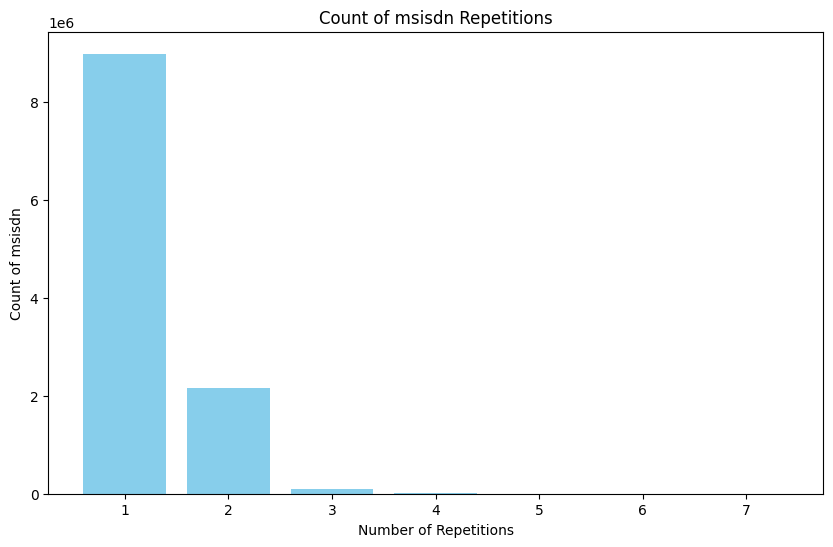

In [10]:
plt.figure(figsize=(10, 6))
plt.bar(repetition_counts_pd['count'], repetition_counts_pd['num_msisdn'], color='skyblue')
plt.xlabel('Number of Repetitions')
plt.ylabel('Count of msisdn')
plt.title('Count of msisdn Repetitions')
plt.xticks(repetition_counts_pd['count'])
plt.show()

In [22]:
import jellyfish


# Cleaning gender columns

In [20]:
gender_values = ['male' , 'female']

def fuzzy_match_with_threshold(value , threshold):
    if value is None:
        return None
    scores = [jellyfish.jaro_winkler_similarity(value.lower() , term) for term in gender_values]
    
    max_index = scores.index(max(scores))
    
    if scores[max_index] >= threshold:
        return gender_values[max_index].capitalize()
    else:
        return None
    

def get_fuzzy_match_udf(threshold):
    return udf(lambda x: fuzzy_match_with_threshold(x, threshold), StringType())

In [23]:
def test_fuzzy_match_with_threshold_empty_string_low_threshold():
    """
    This function tests the fuzzy_match_with_threshold function with an empty string and a low threshold.

    Parameters:
    None

    Returns:
    None

    Raises:
    None
    """
    threshold = 0.0
    value = ""
    result = fuzzy_match_with_threshold(value, threshold)
    print(result)
    assert result is None, f"Expected None, but got {result}"

test_fuzzy_match_with_threshold_empty_string_low_threshold()

Male


AssertionError: Expected None, but got Male

### testing for not match

In [13]:
def test_fuzzy_match_with_threshold_no_match():
    """
    This function tests the fuzzy_match_with_threshold function when there is no match.

    Parameters:
    None

    Returns:
    None
    """
    threshold = 0.0
    value = "Other"
    result = fuzzy_match_with_threshold(value, threshold)
    print(result)
    assert result is None, f"Expected None, but got {result}"
    
test_fuzzy_match_with_threshold_no_match()

Male


AssertionError: Expected None, but got Male

### testing for exact match only

In [14]:
def test_fuzzy_match_with_threshold_exact_match():
    gender_values = ["Male", "Female"]
    threshold = 1.0
    value = "Mal"
    result = fuzzy_match_with_threshold(value, threshold)
    print(result)
    assert result == "Male", f"Expected Male, but got {result}"

test_fuzzy_match_with_threshold_exact_match()

None


AssertionError: Expected Male, but got None

In [15]:
# evaluating threshold

def evaluate_threshold(threshold):
    fuzzy_match_udf = get_fuzzy_match_udf(threshold)
    
    temp_df = crm_data.withColumn('gender_cleaned' , fuzzy_match_udf(col('gender')))
    
    res_df = temp_df.groupBy('gender_cleaned').count().orderBy('count', ascending=False)
    temp_df.select('gender', 'gender_cleaned').distinct().show(100 , truncate=False)
    res_df.show()

In [ ]:

evaluate_threshold(threshold=0.75)

+-------------+--------------+
|gender       |gender_cleaned|
+-------------+--------------+
|F            |Female        |
|Female       |Female        |
|M            |Male          |
|Female3      |Female        |
|Female.      |Female        |
|female       |Female        |
|MALE         |Male          |
|Female]      |Female        |
|FemaleF      |Female        |
|FEMALE       |Female        |
|FE           |Female        |
|Female`      |Female        |
|Femal]e      |Female        |
|Male         |Male          |
|Female..     |Female        |
|male         |Male          |
|Male.        |Male          |
|FEMELE       |Female        |
|A            |Male          |
|mALE         |Male          |
|MaleF        |Male          |
|MaFEle       |Female        |
|FemaleH      |Female        |
|Mal          |Male          |
|MFEale       |Female        |
|MalFEe       |Male          |
|MA           |Male          |
|FAMALE       |Female        |
|Female\\     |Female        |
|FEMAL  

+--------------+-------+
|gender_cleaned|  count|
+--------------+-------+
|          Male|9354064|
|          NULL|2875985|
|        Female|1397444|
+--------------+-------+



In [16]:
# replacing values with udf
fuzzy_match_udf = get_fuzzy_match_udf(threshold=0.75)

crm_data_cleaned = crm_data.withColumn('gender_cleaned' , fuzzy_match_udf(col('gender')))

crm_data_cleaned = crm_data_cleaned.withColumn('gender' , col('gender_cleaned')).drop('gender_cleaned')


crm_data_cleaned.groupBy('gender').count().show(100 , truncate=False)

+------+-------+
|gender|count  |
+------+-------+
|NULL  |2875985|
|Female|1397444|
|Male  |9354064|
+------+-------+



In [ ]:
# null counts in all the columns
crm_data_cleaned.select([count(when(isnull(c), c)).alias(c) for c in crm_data_cleaned.columns]).show(truncate=False)

+------+-------+-------------+-------------+-----------+-------------+
|msisdn|gender |year_of_birth|system_status|mobile_type|value_segment|
+------+-------+-------------+-------------+-----------+-------------+
|0     |2875985|2940         |0            |0          |0            |
+------+-------+-------------+-------------+-----------+-------------+



In [ ]:
# show all distinct year_of_birth values and their counts

yob_counts = crm_data_cleaned.groupBy('year_of_birth').count().orderBy("year_of_birth" , ascending=False)

yob_counts.show(100 , truncate=False)

+-------------+------+
|year_of_birth|count |
+-------------+------+
|2046         |3     |
|2045         |2     |
|2042         |3     |
|2030         |1     |
|2019         |3     |
|2018         |45    |
|2017         |1031  |
|2016         |36    |
|2015         |30    |
|2014         |21    |
|2013         |9     |
|2012         |11    |
|2011         |8     |
|2010         |1     |
|2009         |1     |
|2008         |68    |
|2007         |38    |
|2006         |12    |
|2005         |5     |
|2004         |11    |
|2003         |20    |
|2002         |43    |
|2001         |85    |
|2000         |945   |
|1999         |17235 |
|1998         |53729 |
|1997         |116072|
|1996         |132118|
|1995         |161365|
|1994         |439516|
|1993         |409051|
|1992         |404387|
|1991         |414721|
|1990         |440984|
|1989         |618569|
|1988         |683051|
|1987         |627720|
|1986         |481516|
|1985         |600894|
|1984         |459852|
|1983      

In [17]:
# drop all rows with year_of_birth > 2024

crm_data_cleaned = crm_data_cleaned.filter((col('year_of_birth') < 2024) | (col('year_of_birth').isNull()))

# Show the result to verify the filtering
crm_data_cleaned.show()

+--------------------+------+-------------+-------------+-----------+-------------+
|              msisdn|gender|year_of_birth|system_status|mobile_type|value_segment|
+--------------------+------+-------------+-------------+-----------+-------------+
|aeef4233d9ad34e41...|  Male|         1985|       ACTIVE|    Prepaid|       Tier_3|
|2397d009e705bc8a2...|  Male|         1958|       ACTIVE|    Prepaid|       Tier_3|
|6f05d738919f92833...|  Male|         1976|       ACTIVE|    Prepaid|       Tier_3|
|45352d9d126f86f40...|  Male|         1996|       ACTIVE|    Prepaid|       Tier_3|
|959b00a279e2785cf...|Female|         1960|       ACTIVE|    Prepaid|       Tier_3|
|b74761390712bde13...|  NULL|         1994|       ACTIVE|    Prepaid|       Tier_3|
|b74761390712bde13...|  Male|         1994|       ACTIVE|    Prepaid|       Tier_3|
|1311649d0d7ffeb13...|  Male|         1992|       ACTIVE|    Prepaid|       Tier_3|
|8e6e340aa4b1a4493...|  Male|         1963|       ACTIVE|    Prepaid|       

### Gender and yob columns cleaned stored in crm_data_cleaned dataframe

In [ ]:
# show all duplicates row of one msisdn having repetition 6

crm_data_cleaned.filter(col('msisdn') == '6aac16f4087bb494375bcef30d25ee7e').show(100 , truncate=False)


+--------------------------------+------+-------------+-------------+-----------+-------------+
|msisdn                          |gender|year_of_birth|system_status|mobile_type|value_segment|
+--------------------------------+------+-------------+-------------+-----------+-------------+
|6aac16f4087bb494375bcef30d25ee7e|Male  |1975         |ACTIVE       |Postpaid   |Tier_3       |
|6aac16f4087bb494375bcef30d25ee7e|Female|1989         |ACTIVE       |Postpaid   |Tier_3       |
|6aac16f4087bb494375bcef30d25ee7e|Female|1989         |SUSPEND      |Postpaid   |Tier_3       |
|6aac16f4087bb494375bcef30d25ee7e|Female|1995         |ACTIVE       |Postpaid   |Tier_3       |
|6aac16f4087bb494375bcef30d25ee7e|Male  |1975         |SUSPEND      |Postpaid   |Tier_3       |
|6aac16f4087bb494375bcef30d25ee7e|Male  |1989         |ACTIVE       |Postpaid   |Tier_3       |
+--------------------------------+------+-------------+-------------+-----------+-------------+



In [ ]:
crm_data_cleaned.groupBy('system_status').count().show(20)

+-------------+--------+
|system_status|   count|
+-------------+--------+
|         IDLE|       9|
|      SUSPEND|  285760|
|       ACTIVE|13341714|
|     DEACTIVE|       1|
+-------------+--------+



In [81]:
window_spec = Window.partitionBy("msisdn").orderBy("year_of_birth", "gender" ,"mobile_type", "system_status","value_segment")

In [82]:
df = crm_data_cleaned
df.show()

+--------------------+------+-------------+-------------+-----------+-------------+
|              msisdn|gender|year_of_birth|system_status|mobile_type|value_segment|
+--------------------+------+-------------+-------------+-----------+-------------+
|aeef4233d9ad34e41...|  Male|         1985|       ACTIVE|    Prepaid|       Tier_3|
|2397d009e705bc8a2...|  Male|         1958|       ACTIVE|    Prepaid|       Tier_3|
|6f05d738919f92833...|  Male|         1976|       ACTIVE|    Prepaid|       Tier_3|
|45352d9d126f86f40...|  Male|         1996|       ACTIVE|    Prepaid|       Tier_3|
|959b00a279e2785cf...|Female|         1960|       ACTIVE|    Prepaid|       Tier_3|
|b74761390712bde13...|  NULL|         1994|       ACTIVE|    Prepaid|       Tier_3|
|b74761390712bde13...|  Male|         1994|       ACTIVE|    Prepaid|       Tier_3|
|1311649d0d7ffeb13...|  Male|         1992|       ACTIVE|    Prepaid|       Tier_3|
|8e6e340aa4b1a4493...|  Male|         1963|       ACTIVE|    Prepaid|       

In [83]:
# Add columns to check for adjacent active/suspend pairs within the same SIM card
df = df.withColumn(
    "next_status", lead("system_status").over(window_spec)
).withColumn(
    "next_yob", lead("year_of_birth").over(window_spec)
).withColumn(
    "next_gender", lead("gender").over(window_spec)
).withColumn(
    "prev_status", lag("system_status").over(window_spec)
).withColumn(
    "prev_yob", lag("year_of_birth").over(window_spec)
).withColumn(
    "prev_gender", lag("gender").over(window_spec)
)

In [84]:
df.filter(col('msisdn') == 'ab9f069d44ee8d87660220c4bded9481').show(100 , truncate=False)

+--------------------------------+------+-------------+-------------+-----------+-------------+-----------+--------+-----------+-----------+--------+-----------+
|msisdn                          |gender|year_of_birth|system_status|mobile_type|value_segment|next_status|next_yob|next_gender|prev_status|prev_yob|prev_gender|
+--------------------------------+------+-------------+-------------+-----------+-------------+-----------+--------+-----------+-----------+--------+-----------+
|ab9f069d44ee8d87660220c4bded9481|Male  |1994         |ACTIVE       |Postpaid   |Tier_3       |IDLE       |1994    |Male       |NULL       |NULL    |NULL       |
|ab9f069d44ee8d87660220c4bded9481|Male  |1994         |IDLE         |Postpaid   |Tier_3       |ACTIVE     |1994    |Male       |ACTIVE     |1994    |Male       |
|ab9f069d44ee8d87660220c4bded9481|Male  |1994         |ACTIVE       |Prepaid    |Tier_3       |NULL       |NULL    |NULL       |IDLE       |1994    |Male       |
+---------------------------

In [85]:
df = df.withColumn(
    "pair_flag",
    when(
        (col("system_status") == "ACTIVE") & (col("next_status") == "SUSPEND") & (col("year_of_birth") == col("next_yob")) & (col("gender") == col("next_gender")), 1
    ).when(
        (col("system_status") == "SUSPEND") & (col("prev_status") == "ACTIVE") & (col("year_of_birth") == col("prev_yob")) & (col("gender") == col("prev_gender")), 1
    ).when(
        (col("system_status") == "ACTIVE") & (col("next_status") == "IDLE") & (col("year_of_birth") == col("next_yob")) & (col("gender") == col("next_gender")), 1
    ).otherwise(0)
)

In [86]:
filtered_df = df.filter(col("pair_flag") == 0).drop("pair_flag", "next_status", "next_yob", "next_gender", "prev_status", "prev_yob", "prev_gender")

In [71]:
filtered_df.filter(col('msisdn') == '7f5014e520d1ec441a1e1164c96fa545').show(100 , truncate=False)

+--------------------------------+------+-------------+-------------+-----------+-------------+
|msisdn                          |gender|year_of_birth|system_status|mobile_type|value_segment|
+--------------------------------+------+-------------+-------------+-----------+-------------+
|7f5014e520d1ec441a1e1164c96fa545|NULL  |1950         |ACTIVE       |Postpaid   |Tier_3       |
|7f5014e520d1ec441a1e1164c96fa545|Male  |1979         |ACTIVE       |Postpaid   |Tier_3       |
+--------------------------------+------+-------------+-------------+-----------+-------------+



In [87]:
window_spec_rev = Window.partitionBy("msisdn").orderBy(col("year_of_birth").desc())

In [88]:
filtered_df = filtered_df.withColumn(
    "deactivate_flag",
    when(
        col("system_status") == "DEACTIVATE", 1
    ).otherwise(0)
).withColumn(
    "max_deactivate_flag", max_("deactivate_flag").over(window_spec_rev)
).filter(
    col("max_deactivate_flag") == 0
).drop("deactivate_flag", "max_deactivate_flag")

In [89]:
filtered_df = filtered_df.withColumn(
    "non_null_count",
    sum(
        when(col(c).isNotNull(), 1).otherwise(0) 
        for c in ["gender", "year_of_birth", "system_status", "mobile_type", "value_segment"]
    )
)


In [90]:
# Prioritize records based on status and non-null count
priority_window_spec = Window.partitionBy("msisdn").orderBy(
    when(col("system_status") == "ACTIVE", 1)
    .when(col("system_status") == "IDLE", 2)
    .when(col("system_status") == "SUSPEND", 3)
    .when(col("system_status") == "DEACTIVATE", 4)
    .asc(),
    col("non_null_count").desc(),  # Higher priority to rows with more non-null values
    # Younger year of birth gets higher priority
)

In [91]:

priority_df = filtered_df.withColumn(
    "priority", row_number().over(priority_window_spec)
)

In [92]:
priority_df.filter(col('msisdn') == 'ab9f069d44ee8d87660220c4bded9481').show(100 , truncate=False)

+--------------------------------+------+-------------+-------------+-----------+-------------+--------------+--------+
|msisdn                          |gender|year_of_birth|system_status|mobile_type|value_segment|non_null_count|priority|
+--------------------------------+------+-------------+-------------+-----------+-------------+--------------+--------+
|ab9f069d44ee8d87660220c4bded9481|Male  |1994         |ACTIVE       |Prepaid    |Tier_3       |5             |1       |
|ab9f069d44ee8d87660220c4bded9481|Male  |1994         |IDLE         |Postpaid   |Tier_3       |5             |2       |
+--------------------------------+------+-------------+-------------+-----------+-------------+--------------+--------+



In [93]:
# Select records with most information
final_df = priority_df.withColumn(
    "gender", first("gender").over(Window.partitionBy("msisdn").orderBy("priority"))
).withColumn(
    "year_of_birth", first("year_of_birth").over(Window.partitionBy("msisdn").orderBy("priority"))
).withColumn(
    "system_status", first("system_status").over(Window.partitionBy("msisdn").orderBy("priority"))
).withColumn(
    "mobile_type", first("mobile_type").over(Window.partitionBy("msisdn").orderBy("priority"))
).withColumn(
    "value_segment", first("value_segment").over(Window.partitionBy("msisdn").orderBy("priority"))
).filter(
    col("priority") == 1
).select(
    "msisdn", "gender", "year_of_birth", "system_status", "mobile_type", "value_segment"
).distinct()

In [38]:
# show rows with msisdn and their duplicate counts

crm_data_cleaned.groupBy('msisdn').count().orderBy("count" , ascending=False).show(100 , truncate=False)


24/06/08 22:15:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 22:15:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 22:15:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 22:15:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 22:15:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 22:15:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 22:15:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 22:15:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 22:15:13 WARN RowBasedKeyValueBatch: Calling spill() on

+--------------------------------+-----+
|msisdn                          |count|
+--------------------------------+-----+
|7635388988f5ecaca897aa1a07a88a7a|7    |
|bcee0f2e693cf86fe8eb1456ad2df849|7    |
|31fa2d91f82186152d1cc135e7f63ab4|6    |
|de1e739b32ca5b2b25c6d11f672283d7|6    |
|7f5014e520d1ec441a1e1164c96fa545|6    |
|abd4056b0143b350fde116a9b09c274c|6    |
|88a8160ea8d43b962ed7881410dd071e|6    |
|325cd0ed693cf031b5837fc728257d16|6    |
|d9bae626f39ca0bb7a17a58e6969cf68|6    |
|5277c9aaa1455867c99126b78b816134|6    |
|7e8c6fe93347b2fc47133c1ce48cd879|6    |
|a73cd2de0ce54b6cacb9c77713615d8b|6    |
|0e05e9e4d730b5625faf061d96dd04b5|6    |
|5699c8048772a92fa3ca13cc801041e5|6    |
|38b4c5bb5d1535b51bf5eff64e5cc956|6    |
|692128769e027398e222d2d9ba9b413e|6    |
|112d4de40600d0510e6512f1c1b1ff82|6    |
|c6798699ac319d4963eb3405fcbfd0ce|6    |
|ffaad67a738b0e8460604aabe01e1394|6    |
|e12deb1066c6269c63158f3b4a6aaab5|6    |
|5ad992846b80d0c977e3ec3b07ea7ebd|6    |
|f41e85d07a6c699

In [94]:

crm_data_cleaned.filter(col('msisdn') == '6aac16f4087bb494375bcef30d25ee7e').show(100 , truncate=False)

final_df.filter(col('msisdn') == '6aac16f4087bb494375bcef30d25ee7e').show(100 , truncate=False)

+--------------------------------+------+-------------+-------------+-----------+-------------+
|msisdn                          |gender|year_of_birth|system_status|mobile_type|value_segment|
+--------------------------------+------+-------------+-------------+-----------+-------------+
|6aac16f4087bb494375bcef30d25ee7e|Male  |1975         |ACTIVE       |Postpaid   |Tier_3       |
|6aac16f4087bb494375bcef30d25ee7e|Female|1989         |ACTIVE       |Postpaid   |Tier_3       |
|6aac16f4087bb494375bcef30d25ee7e|Female|1989         |SUSPEND      |Postpaid   |Tier_3       |
|6aac16f4087bb494375bcef30d25ee7e|Female|1995         |ACTIVE       |Postpaid   |Tier_3       |
|6aac16f4087bb494375bcef30d25ee7e|Male  |1975         |SUSPEND      |Postpaid   |Tier_3       |
|6aac16f4087bb494375bcef30d25ee7e|Male  |1989         |ACTIVE       |Postpaid   |Tier_3       |
+--------------------------------+------+-------------+-------------+-----------+-------------+



+--------------------------------+------+-------------+-------------+-----------+-------------+
|msisdn                          |gender|year_of_birth|system_status|mobile_type|value_segment|
+--------------------------------+------+-------------+-------------+-----------+-------------+
|6aac16f4087bb494375bcef30d25ee7e|Female|1995         |ACTIVE       |Postpaid   |Tier_3       |
+--------------------------------+------+-------------+-------------+-----------+-------------+



### Testing different scenarios

In [95]:

crm_data_cleaned.filter(col('msisdn') == '7f5014e520d1ec441a1e1164c96fa545').show(100 , truncate=False)

final_df.filter(col('msisdn') == '7f5014e520d1ec441a1e1164c96fa545').show(100 , truncate=False)

+--------------------------------+------+-------------+-------------+-----------+-------------+
|msisdn                          |gender|year_of_birth|system_status|mobile_type|value_segment|
+--------------------------------+------+-------------+-------------+-----------+-------------+
|7f5014e520d1ec441a1e1164c96fa545|Male  |1950         |SUSPEND      |Postpaid   |Tier_3       |
|7f5014e520d1ec441a1e1164c96fa545|Male  |1985         |SUSPEND      |Postpaid   |Tier_3       |
|7f5014e520d1ec441a1e1164c96fa545|Male  |1979         |ACTIVE       |Postpaid   |Tier_3       |
|7f5014e520d1ec441a1e1164c96fa545|Male  |1985         |ACTIVE       |Postpaid   |Tier_3       |
|7f5014e520d1ec441a1e1164c96fa545|NULL  |1950         |ACTIVE       |Postpaid   |Tier_3       |
|7f5014e520d1ec441a1e1164c96fa545|Male  |1950         |ACTIVE       |Postpaid   |Tier_3       |
+--------------------------------+------+-------------+-------------+-----------+-------------+



+--------------------------------+------+-------------+-------------+-----------+-------------+
|msisdn                          |gender|year_of_birth|system_status|mobile_type|value_segment|
+--------------------------------+------+-------------+-------------+-----------+-------------+
|7f5014e520d1ec441a1e1164c96fa545|Male  |1979         |ACTIVE       |Postpaid   |Tier_3       |
+--------------------------------+------+-------------+-------------+-----------+-------------+



In [96]:

crm_data_cleaned.filter(col('msisdn') == '39b32632b7b0746f190113be77366435').show(100 , truncate=False)

final_df.filter(col('msisdn') == '39b32632b7b0746f190113be77366435').show(100 , truncate=False)

+--------------------------------+------+-------------+-------------+-----------+-------------+
|msisdn                          |gender|year_of_birth|system_status|mobile_type|value_segment|
+--------------------------------+------+-------------+-------------+-----------+-------------+
|39b32632b7b0746f190113be77366435|NULL  |1983         |ACTIVE       |Postpaid   |Tier_3       |
|39b32632b7b0746f190113be77366435|Male  |1983         |ACTIVE       |Postpaid   |Tier_3       |
|39b32632b7b0746f190113be77366435|Male  |1981         |SUSPEND      |Postpaid   |Tier_3       |
|39b32632b7b0746f190113be77366435|Male  |1981         |ACTIVE       |Postpaid   |Tier_3       |
|39b32632b7b0746f190113be77366435|NULL  |1987         |ACTIVE       |Postpaid   |Tier_3       |
+--------------------------------+------+-------------+-------------+-----------+-------------+



+--------------------------------+------+-------------+-------------+-----------+-------------+
|msisdn                          |gender|year_of_birth|system_status|mobile_type|value_segment|
+--------------------------------+------+-------------+-------------+-----------+-------------+
|39b32632b7b0746f190113be77366435|Male  |1983         |ACTIVE       |Postpaid   |Tier_3       |
+--------------------------------+------+-------------+-------------+-----------+-------------+



In [39]:

crm_data_cleaned.filter(col('msisdn') == 'a45eba5d8954b92cfc852e70f8ac32de').show(100 , truncate=False)

final_df.filter(col('msisdn') == 'a45eba5d8954b92cfc852e70f8ac32de').show(100 , truncate=False)

+--------------------------------+------+-------------+-------------+-----------+-------------+
|msisdn                          |gender|year_of_birth|system_status|mobile_type|value_segment|
+--------------------------------+------+-------------+-------------+-----------+-------------+
|a45eba5d8954b92cfc852e70f8ac32de|NULL  |1989         |ACTIVE       |Prepaid    |Tier_3       |
|a45eba5d8954b92cfc852e70f8ac32de|Male  |1989         |ACTIVE       |Prepaid    |Tier_3       |
|a45eba5d8954b92cfc852e70f8ac32de|Male  |1989         |ACTIVE       |Prepaid    |Tier_3       |
|a45eba5d8954b92cfc852e70f8ac32de|NULL  |1993         |ACTIVE       |Prepaid    |Tier_3       |
|a45eba5d8954b92cfc852e70f8ac32de|Male  |1993         |ACTIVE       |Prepaid    |Tier_3       |
+--------------------------------+------+-------------+-------------+-----------+-------------+



+--------------------------------+------+-------------+-------------+-----------+-------------+
|msisdn                          |gender|year_of_birth|system_status|mobile_type|value_segment|
+--------------------------------+------+-------------+-------------+-----------+-------------+
|a45eba5d8954b92cfc852e70f8ac32de|Male  |1993         |ACTIVE       |Prepaid    |Tier_3       |
+--------------------------------+------+-------------+-------------+-----------+-------------+



In [97]:

crm_data_cleaned.filter(col('msisdn') == '2929b5db8ae5420ae4db599f1ca6c531').show(100 , truncate=False)

final_df.filter(col('msisdn') == '2929b5db8ae5420ae4db599f1ca6c531').show(100 , truncate=False)

+--------------------------------+------+-------------+-------------+-----------+-------------+
|msisdn                          |gender|year_of_birth|system_status|mobile_type|value_segment|
+--------------------------------+------+-------------+-------------+-----------+-------------+
|2929b5db8ae5420ae4db599f1ca6c531|Male  |1977         |ACTIVE       |Postpaid   |Tier_3       |
|2929b5db8ae5420ae4db599f1ca6c531|NULL  |1977         |SUSPEND      |Postpaid   |Tier_3       |
|2929b5db8ae5420ae4db599f1ca6c531|NULL  |1997         |ACTIVE       |Postpaid   |Tier_3       |
|2929b5db8ae5420ae4db599f1ca6c531|NULL  |1993         |ACTIVE       |Postpaid   |Tier_3       |
|2929b5db8ae5420ae4db599f1ca6c531|NULL  |1977         |ACTIVE       |Postpaid   |Tier_3       |
+--------------------------------+------+-------------+-------------+-----------+-------------+



+--------------------------------+------+-------------+-------------+-----------+-------------+
|msisdn                          |gender|year_of_birth|system_status|mobile_type|value_segment|
+--------------------------------+------+-------------+-------------+-----------+-------------+
|2929b5db8ae5420ae4db599f1ca6c531|Male  |1977         |ACTIVE       |Postpaid   |Tier_3       |
+--------------------------------+------+-------------+-------------+-----------+-------------+



In [99]:
crm_data_cleaned.filter(col('system_status') == 'DEACTIVATE').show(100 , truncate=False)

+------+------+-------------+-------------+-----------+-------------+
|msisdn|gender|year_of_birth|system_status|mobile_type|value_segment|
+------+------+-------------+-------------+-----------+-------------+
+------+------+-------------+-------------+-----------+-------------+



In [98]:
crm_data_cleaned.filter(col('msisdn') == 'ab9f069d44ee8d87660220c4bded9481').show(100 , truncate=False)
final_df.filter(col('msisdn') == 'ab9f069d44ee8d87660220c4bded9481').show(100 , truncate=False)

+--------------------------------+------+-------------+-------------+-----------+-------------+
|msisdn                          |gender|year_of_birth|system_status|mobile_type|value_segment|
+--------------------------------+------+-------------+-------------+-----------+-------------+
|ab9f069d44ee8d87660220c4bded9481|Male  |1994         |IDLE         |Postpaid   |Tier_3       |
|ab9f069d44ee8d87660220c4bded9481|Male  |1994         |ACTIVE       |Postpaid   |Tier_3       |
|ab9f069d44ee8d87660220c4bded9481|Male  |1994         |ACTIVE       |Prepaid    |Tier_3       |
+--------------------------------+------+-------------+-------------+-----------+-------------+



+--------------------------------+------+-------------+-------------+-----------+-------------+
|msisdn                          |gender|year_of_birth|system_status|mobile_type|value_segment|
+--------------------------------+------+-------------+-------------+-----------+-------------+
|ab9f069d44ee8d87660220c4bded9481|Male  |1994         |ACTIVE       |Prepaid    |Tier_3       |
+--------------------------------+------+-------------+-------------+-----------+-------------+



In [102]:
# Step 2: Calculate repetitions in cleaned final_df
msisdn_counts_after = final_df.groupBy('msisdn').agg(count('msisdn').alias('count'))
repetition_counts_after = msisdn_counts_after.groupBy('count').agg(count('msisdn').alias('num_msisdn')).orderBy('count')

# Convert to Pandas DataFrames for easier manipulation
repetition_counts_before_pd = repetition_counts.toPandas()
repetition_counts_after_pd = repetition_counts_after.toPandas()

# Step 3: Prepare the data for visualization
repetition_counts_before_pd['status'] = 'Before Cleaning'
repetition_counts_after_pd['status'] = 'After Cleaning'

combined_df = pd.concat([repetition_counts_before_pd, repetition_counts_after_pd])



24/06/08 23:39:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:39:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:39:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:39:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:39:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:39:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:39:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:39:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:39:16 WARN RowBasedKeyValueBatch: Calling spill() on

[6657.555s][warning][gc,alloc] Executor task launch worker for task 2.0 in stage 208.0 (TID 591): Retried waiting for GCLocker too often allocating 1048578 words


24/06/08 23:40:01 WARN TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
24/06/08 23:40:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:40:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:40:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:40:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:40:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:40:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:40:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:40:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatc

[6666.511s][warning][gc,alloc] Executor task launch worker for task 4.0 in stage 208.0 (TID 593): Retried waiting for GCLocker too often allocating 2097154 words


24/06/08 23:40:10 WARN TaskMemoryManager: Failed to allocate a page (16777216 bytes), try again.
24/06/08 23:40:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:40:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:40:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:40:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:40:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:40:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:40:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:40:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBat

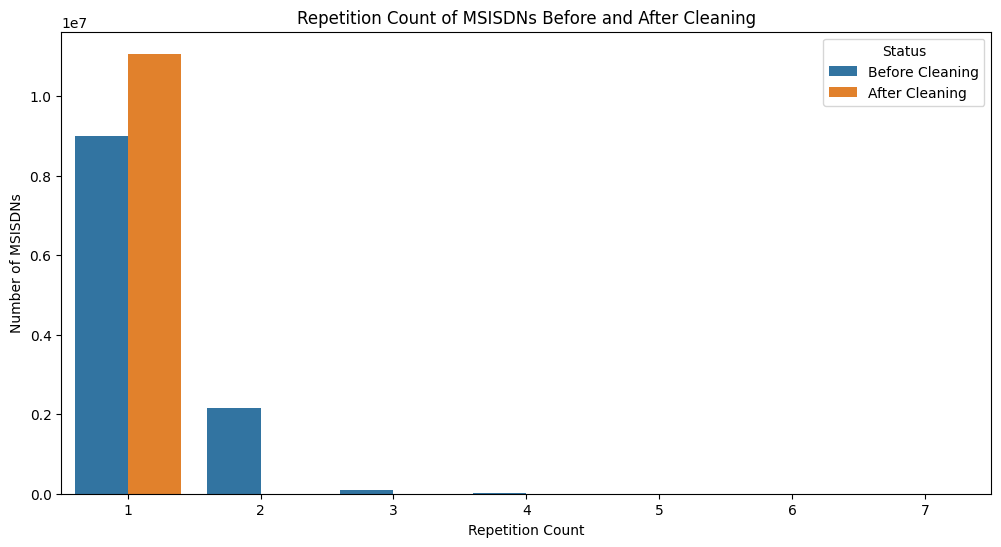

In [103]:
# Step 4: Plot the results using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='num_msisdn', hue='status', data=combined_df)
plt.xlabel('Repetition Count')
plt.ylabel('Number of MSISDNs')
plt.title('Repetition Count of MSISDNs Before and After Cleaning')
plt.legend(title='Status')
plt.show()

In [104]:
# Step 1: Count null values in the gender column in the original crm_data
null_gender_before = crm_data.filter(crm_data.gender.isNull()).count()

# Step 2: Count null values in the gender column in the cleaned final_df
null_gender_after = final_df.filter(final_df.gender.isNull()).count()

# Step 3: Prepare the data for visualization
null_counts = pd.DataFrame({
    'status': ['Before Cleaning', 'After Cleaning'],
    'null_count': [null_gender_before, null_gender_after]
})



24/06/08 23:45:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:45:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:45:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:45:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:45:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:45:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:45:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:45:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 23:45:07 WARN RowBasedKeyValueBatch: Calling spill() on

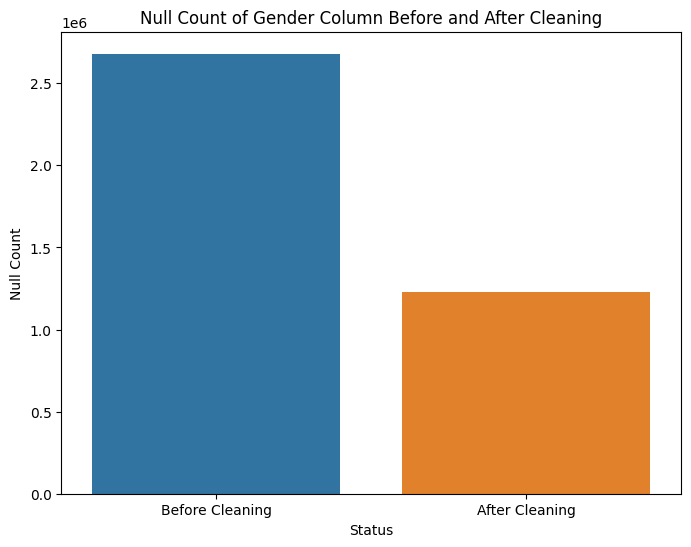

24/06/09 04:37:49 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1085666 ms exceeds timeout 120000 ms
24/06/09 04:37:49 WARN SparkContext: Killing executors is not supported by current scheduler.
24/06/09 04:37:52 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

In [108]:
plt.figure(figsize=(8, 6))
sns.barplot(x='status', y='null_count', data=null_counts , hue='status')
plt.xlabel('Status')
plt.ylabel('Null Count')
plt.title('Null Count of Gender Column Before and After Cleaning')
plt.show()

#### final null counts of all columns after cleaning 

In [ ]:
# null values in all columns
crm_final.select([count(when(isnull(c), c)).alias(c) for c in crm_final.columns]).show(truncate=False)


NameError: name 'crm_final' is not defined

In [55]:
# null values in all columns
final_df.select([count(when(isnull(c), c)).alias(c) for c in final_df.columns]).show(truncate=False)


24/06/08 22:27:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 22:27:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 22:27:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 22:27:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 22:27:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 22:27:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 22:27:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 22:27:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 22:27:42 WARN RowBasedKeyValueBatch: Calling spill() on

[2318.983s][warning][gc,alloc] Executor task launch worker for task 3.0 in stage 106.0 (TID 306): Retried waiting for GCLocker too often allocating 1048578 words


24/06/08 22:27:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 22:27:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 22:27:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 22:27:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 22:27:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 22:27:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 22:27:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 22:27:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/06/08 22:27:43 WARN RowBasedKeyValueBatch: Calling spill() on

+------+-------+-------------+-------------+-----------+-------------+
|msisdn|gender |year_of_birth|system_status|mobile_type|value_segment|
+------+-------+-------------+-------------+-----------+-------------+
|0     |1225576|193          |0            |0          |0            |
+------+-------+-------------+-------------+-----------+-------------+



In [ ]:
crm_final = final_df

--------------------------------------------------------------------------------
### CRM completely cleaned and stored in crm_final dataframe
--------------------------------------------------------------------------------

In [ ]:
device_data.show(truncate=False)

+--------------------------------+--------------------------------+------------------------+--------------------------+--------------+--------------+
|msisdn                          |imei_tac                        |brand_name              |model_name                |os_name       |os_vendor     |
+--------------------------------+--------------------------------+------------------------+--------------------------+--------------+--------------+
|c0e80ecc67484f293db0cf723146c9d6|7ce90a5469d6a07dc8c770956cc29482|SAMSUNG                 |GALAXY J1 ACE (SM-J111F)  |Android       |Google        |
|2bce0cd398cbc9b2478ecaf1ef62b2c1|110f73736e1e1fe0ef5cb8a581bc0ec2|WALTON                  |OLVIO L22                 |NULL          |NULL          |
|d7b8b49fafb853a3aef0c20d49bca845|ddf90b7c597d7714637ecde342a8c609|LG                      |W1500                     |LG OS         |LG            |
|d628f3b548dc74c5fde92323c61c819e|c395eac49569e6741faf98284aef725c|SYMPHONY                |B13     

In [ ]:
# give the count of null values in each column

device_data.select([count(when(isnull(c), c)).alias(c) for c in device_data.columns]).show(truncate=False)

+------+--------+----------+----------+-------+---------+
|msisdn|imei_tac|brand_name|model_name|os_name|os_vendor|
+------+--------+----------+----------+-------+---------+
|0     |0       |30446     |30446     |677714 |660472   |
+------+--------+----------+----------+-------+---------+



In [ ]:
# number of repetitions and their corresponding count of msisdn values for each repettiton value

msisdn_count_dev = device_data.groupBy('msisdn').agg(count('msisdn').alias('count'))

# Group by the count of repetitions and count the number of msisdn for each count
repetition_count_dev = msisdn_count_dev.groupBy('count').agg(count('msisdn').alias('num_msisdn'))

# Order by count and show the results
repetition_count_dev.orderBy('count').show()



+-----+----------+
|count|num_msisdn|
+-----+----------+
|    1|   2324838|
|    2|     56130|
|    3|       990|
|    4|         8|
+-----+----------+



In [ ]:
# show msisdn values for which repetitions is 4

msisdn_count_4 = msisdn_count_dev.filter(col('count') == 4)

msisdn_count_4.show(10 , truncate=False)


+--------------------------------+-----+
|msisdn                          |count|
+--------------------------------+-----+
|b6f91fd027a1c973e7a9e5ed3bd312e5|4    |
|96c57bd8a86f1d9f87d0289e29f262da|4    |
|e1cd2d3558a317fccf8a97bddfe139e5|4    |
|aa4811f3eab37e51aadc5d19d4cd80fc|4    |
|7dc6f4d405178eba36eacbba5d5ad01f|4    |
|faa0c85e65988600cf9f2ebc19ee120d|4    |
|97f47782b24d66b8cb82db6dcffc784c|4    |
|92e260dbf65d96dc2c2099628549cab8|4    |
+--------------------------------+-----+



In [ ]:
device_data.filter(col("msisdn") == "96c57bd8a86f1d9f87d0289e29f262da").show(truncate=False)

+--------------------------------+--------------------------------+----------+----------------------------------+-------+---------+
|msisdn                          |imei_tac                        |brand_name|model_name                        |os_name|os_vendor|
+--------------------------------+--------------------------------+----------+----------------------------------+-------+---------+
|96c57bd8a86f1d9f87d0289e29f262da|cd5c4110622d5679573664526be5595c|SAMSUNG   |GALAXY J2 PRIME DUOS (SM-G532G DS)|Android|Google   |
|96c57bd8a86f1d9f87d0289e29f262da|f064cc5433eecac32b72b516d56048a1|SAMSUNG   |GALAXY TREND II (SM-G318HZDS)     |Android|Google   |
|96c57bd8a86f1d9f87d0289e29f262da|0db28378886f8654c9ac8f78ae90c2e9|SAMSUNG   |GALAXY J2 PRIME DUOS (SM-G532G DS)|Android|Google   |
|96c57bd8a86f1d9f87d0289e29f262da|a3861c7edef459b8b9c34238d098fe18|SYMPHONY  |BL110                             |NULL   |NULL     |
+--------------------------------+--------------------------------+---------

In [ ]:
device_data.filter(col("msisdn") == "7dc6f4d405178eba36eacbba5d5ad01f").show(truncate=False)

+--------------------------------+--------------------------------+----------+---------------------------------+-------+---------+
|msisdn                          |imei_tac                        |brand_name|model_name                       |os_name|os_vendor|
+--------------------------------+--------------------------------+----------+---------------------------------+-------+---------+
|7dc6f4d405178eba36eacbba5d5ad01f|7664583ddfadb8d4f537ccedaed08186|SAMSUNG   |GALAXY J2 (SM-J200H)             |Android|Google   |
|7dc6f4d405178eba36eacbba5d5ad01f|a19ed3d63012610ee6746e2f0e89849b|SAMSUNG   |GALAXY J3 2016 DUOS (SM-J320F DS)|Android|Google   |
|7dc6f4d405178eba36eacbba5d5ad01f|a722b7581fc0d7b1ff5ab22a5bffeca6|SAMSUNG   |GALAXY J3 2016 DUOS (SM-J320F DS)|Android|Google   |
|7dc6f4d405178eba36eacbba5d5ad01f|2679c51b4693f962946862896d80e791|SAMSUNG   |GALAXY J2 DUOS (SM-J200F DS)     |Android|Google   |
+--------------------------------+--------------------------------+----------+-----

In [ ]:
device_data.filter(col("msisdn") == "96c57bd8a86f1d9f87d0289e29f262da").show(truncate=False)

+--------------------------------+--------------------------------+----------+----------------------------------+-------+---------+
|msisdn                          |imei_tac                        |brand_name|model_name                        |os_name|os_vendor|
+--------------------------------+--------------------------------+----------+----------------------------------+-------+---------+
|96c57bd8a86f1d9f87d0289e29f262da|cd5c4110622d5679573664526be5595c|SAMSUNG   |GALAXY J2 PRIME DUOS (SM-G532G DS)|Android|Google   |
|96c57bd8a86f1d9f87d0289e29f262da|f064cc5433eecac32b72b516d56048a1|SAMSUNG   |GALAXY TREND II (SM-G318HZDS)     |Android|Google   |
|96c57bd8a86f1d9f87d0289e29f262da|0db28378886f8654c9ac8f78ae90c2e9|SAMSUNG   |GALAXY J2 PRIME DUOS (SM-G532G DS)|Android|Google   |
|96c57bd8a86f1d9f87d0289e29f262da|a3861c7edef459b8b9c34238d098fe18|SYMPHONY  |BL110                             |NULL   |NULL     |
+--------------------------------+--------------------------------+---------

In [ ]:
# show all the distinct brand name values and thier count of occurence

brand_cnt = device_data.groupBy('brand_name').count().orderBy("count" , ascending=False)

brand_cnt = brand_cnt.withColumn("sno", row_number().over(Window.orderBy("brand_name")))

brand_cnt.show(100 , truncate=False)

24/06/05 16:01:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/05 16:01:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/05 16:01:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------------------------------------+-----+---+
|brand_name                          |count|sno|
+------------------------------------+-----+---+
|NULL                                |30446|1  |
|3GNET                               |6    |2  |
|6DEGREE                             |408  |3  |
|A-LINK                              |3    |4  |
|AACE IMPEX LIMITED                  |1    |5  |
|AAHAN                               |2    |6  |
|AAMRA                               |7767 |7  |
|ABANS                               |2    |8  |
|ACE                                 |27   |9  |
|ACER                                |139  |10 |
|ADAMS FUTURE                        |1    |11 |
|ADAPT GLOBAL                        |5    |12 |
|ADART COMPUTERS                     |2    |13 |
|ADDTEL                              |7    |14 |
|ADMET                               |6    |15 |
|ADRANT LIMITED                      |62   |16 |
|ADVAN                               |32   |17 |
|ADVANCED CHEMICAL I

24/06/05 16:01:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/05 16:01:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/05 16:01:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [ ]:
model_cnt = device_data.groupBy('model_name').count().orderBy("count" , ascending=False)

model_cnt = model_cnt.withColumn("sno", row_number().over(Window.orderBy("model_name")))

model_cnt.show(100 , truncate=False)

24/06/05 16:01:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/05 16:01:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/05 16:01:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------------------------+-----+---+
|model_name                  |count|sno|
+----------------------------+-----+---+
|NULL                        |30446|1  |
|(T1,T2)                     |3    |2  |
|009Z                        |1    |3  |
|00X (ME375CL)               |1    |4  |
|012                         |1    |5  |
|012, K52, K62, X328         |43   |6  |
|050MA-K (MP0100903)         |3    |7  |
|0P6B650                     |4    |8  |
|0P6B670                     |23   |9  |
|0P6B680                     |2    |10 |
|0P6B810                     |90   |11 |
|0P9C500                     |46   |12 |
|0P9O100                     |9    |13 |
|0PAG200                     |2    |14 |
|0PAJ100                     |1    |15 |
|0PAJ310                     |15   |16 |
|0PAJ400                     |3    |17 |
|0PCV220                     |2    |18 |
|0PCV220_T                   |1    |19 |
|0PFH210                     |4    |20 |
|0PGL100                     |19   |21 |
|0PGQ120        

24/06/05 16:01:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/05 16:01:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/06/05 16:01:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [ ]:
# count of rows in which both os_name and os_vendor are null

device_data.filter(col('os_name').isNull() & col('os_vendor').isNull()).count()

660457

In [ ]:
# count of rows in which both os_name and os_vendor are null but brand_name or model_name is present

device_data.filter(col('os_name').isNull() & col('os_vendor').isNull() & (col('brand_name').isNotNull())).count()

630011

In [ ]:
device_data.filter(col('os_name').isNull() & col('os_vendor').isNull() & (col('brand_name').isNotNull() | col('model_name').isNotNull())).show()

+--------------------+--------------------+--------------------+----------+-------+---------+
|              msisdn|            imei_tac|          brand_name|model_name|os_name|os_vendor|
+--------------------+--------------------+--------------------+----------+-------+---------+
|2bce0cd398cbc9b24...|110f73736e1e1fe0e...|              WALTON| OLVIO L22|   NULL|     NULL|
|d628f3b548dc74c5f...|c395eac49569e6741...|            SYMPHONY|       B13|   NULL|     NULL|
|8ed54c77279bfe313...|a214f011d36d222d6...|                ITEL|    IT5231|   NULL|     NULL|
|c93094db10fe8c60c...|61cd8b39ab39ecac0...|            SYMPHONY|      D52I|   NULL|     NULL|
|c7804272216fd3173...|3058d7c7b298c97da...|PHONE CARE AXIOM ...|B104 JOY 3|   NULL|     NULL|
|3d10eab1c42bc039b...|638748d45c0965368...|            SYMPHONY|       D22|   NULL|     NULL|
|483351b7ab287b1da...|f9676f4bf10656cb0...|                LAVA|   ARC 101|   NULL|     NULL|
|76ed97f48f0f3cc75...|f16733a2b000319dc...|            SYMPH

In [5]:
dev_not_null = device_data.filter(col('os_name').isNotNull() & col('os_vendor').isNotNull())
window_spec = Window.partitionBy("brand_name").orderBy(desc("count"))
dev_not_null.count()


1762371

In [6]:
brand_os_count = dev_not_null.groupBy("brand_name", "os_name", "os_vendor").count()

ranked_os = brand_os_count.withColumn("rank", row_number().over(window_spec))

most_frequent_os = ranked_os.filter(col("rank") == 1).select("brand_name", "os_name", "os_vendor")

ranked_os.show(truncate=False)


+------------+--------------+--------------+-----+----+
|brand_name  |os_name       |os_vendor     |count|rank|
+------------+--------------+--------------+-----+----+
|3GNET       |Proprietary OS|Proprietary OS|1    |1   |
|6DEGREE     |Proprietary OS|Proprietary OS|408  |1   |
|A-LINK      |Android       |Google        |2    |1   |
|AAMRA       |Android       |Google        |7751 |1   |
|AAMRA       |Windows phone |Microsoft     |16   |2   |
|ABANS       |MTK RTOS      |Motorola      |2    |1   |
|ACE         |Proprietary OS|Proprietary OS|4    |1   |
|ACER        |Android       |Google        |135  |1   |
|ACER        |Windows phone |Microsoft     |4    |2   |
|ADAMS FUTURE|Android       |Google        |1    |1   |
|ADDTEL      |Proprietary OS|Proprietary OS|3    |1   |
|ADMET       |Proprietary OS|Proprietary OS|2    |1   |
|ADVAN       |Android       |Google        |30   |1   |
|AEG         |Proprietary OS|Proprietary OS|1    |1   |
|AF          |Android       |Google        |2   

### Brand and OS mapping 


In [7]:
most_frequent_os = most_frequent_os.withColumnRenamed("os_name", "most_frequent_os_name").withColumnRenamed("os_vendor", "most_frequent_os_vendor")

most_frequent_os.show(100 , truncate=False)

+-----------------------+---------------------+-----------------------+
|brand_name             |most_frequent_os_name|most_frequent_os_vendor|
+-----------------------+---------------------+-----------------------+
|3GNET                  |Proprietary OS       |Proprietary OS         |
|6DEGREE                |Proprietary OS       |Proprietary OS         |
|A-LINK                 |Android              |Google                 |
|AAMRA                  |Android              |Google                 |
|ABANS                  |MTK RTOS             |Motorola               |
|ACE                    |Proprietary OS       |Proprietary OS         |
|ACER                   |Android              |Google                 |
|ADAMS FUTURE           |Android              |Google                 |
|ADDTEL                 |Proprietary OS       |Proprietary OS         |
|ADMET                  |Proprietary OS       |Proprietary OS         |
|ADVAN                  |Android              |Google           

In [ ]:
most_frequent_os.count()

836

In [8]:
device_with_os = device_data.join(most_frequent_os, on="brand_name", how="left")

device_with_os.show(100 , truncate=False)

+------------------------+--------------------------------+--------------------------------+--------------------------------------------+--------------+--------------+---------------------+-----------------------+
|brand_name              |msisdn                          |imei_tac                        |model_name                                  |os_name       |os_vendor     |most_frequent_os_name|most_frequent_os_vendor|
+------------------------+--------------------------------+--------------------------------+--------------------------------------------+--------------+--------------+---------------------+-----------------------+
|MAXIMUS                 |21c932fc3b419b04393b7f7432b72270|aae11d9f32dec67df517863c0c772225|M80                                         |Proprietary OS|Proprietary OS|Proprietary OS       |Proprietary OS         |
|DARAGO                  |6235e7b16eef123f55d5a9239fe3cf07|03989b317df16f4786814fee50c9d585|301,I6,V1,V60,108                           |Proprie

In [ ]:
device_with_os.count()

2440100

In [ ]:
# in device_with_os, find count of os_name and os_vendor missing but most_frequent_os and most_frequent_osvendor present


device_with_os.filter(col('os_name').isNull() & col('os_vendor').isNull() & col('most_frequent_os_name').isNotNull() & col('most_frequent_os_vendor').isNotNull()).count()

580267

In [11]:
device_filled = device_with_os.withColumn(
    "os_name",
    when(col("os_name").isNull() & col("os_vendor").isNull(), col("most_frequent_os_name")).otherwise(col("os_name"))
)

device_filled.show(100 , truncate=False)


+------------------------+--------------------------------+--------------------------------+--------------------------------------------+--------------+--------------+---------------------+-----------------------+
|brand_name              |msisdn                          |imei_tac                        |model_name                                  |os_name       |os_vendor     |most_frequent_os_name|most_frequent_os_vendor|
+------------------------+--------------------------------+--------------------------------+--------------------------------------------+--------------+--------------+---------------------+-----------------------+
|MAXIMUS                 |21c932fc3b419b04393b7f7432b72270|aae11d9f32dec67df517863c0c772225|M80                                         |Proprietary OS|Proprietary OS|Proprietary OS       |Proprietary OS         |
|DARAGO                  |6235e7b16eef123f55d5a9239fe3cf07|03989b317df16f4786814fee50c9d585|301,I6,V1,V60,108                           |Proprie

In [12]:
device_filled = device_filled.withColumn(
    "os_vendor",
    when(col("most_frequent_os_vendor").isNotNull() & col("os_vendor").isNull(), col("most_frequent_os_vendor")).otherwise(col("os_vendor"))
)

In [ ]:
# count of missing most_frequent_os_vendor 

device_filled.filter(col('most_frequent_os_name').isNull() & col('most_frequent_os_vendor').isNull()).count()

80197

In [13]:
device_filled = device_filled.drop("most_frequent_os_name", "most_frequent_os_vendor")
device_filled.show()

+--------------------+--------------------+--------------------+--------------------+--------------+--------------+
|          brand_name|              msisdn|            imei_tac|          model_name|       os_name|     os_vendor|
+--------------------+--------------------+--------------------+--------------------+--------------+--------------+
|            SYMPHONY|d628f3b548dc74c5f...|c395eac49569e6741...|                 B13|       Android|        Google|
|            SYMPHONY|c93094db10fe8c60c...|61cd8b39ab39ecac0...|                D52I|       Android|        Google|
|            SYMPHONY|b060a4c25f9d86848...|88e581b67db0c460c...| B9, FT34, B11I, H50|Proprietary OS|Proprietary OS|
|            SYMPHONY|3d10eab1c42bc039b...|638748d45c0965368...|                 D22|       Android|        Google|
|            SYMPHONY|76ed97f48f0f3cc75...|f16733a2b000319dc...|                 D22|       Android|        Google|
|               NOKIA|b15e7a71a459ba9a4...|8a0150c6a9e697d20...|      3 

In [ ]:
device_filled.count()

2440100

In [ ]:
# give count of records where both os_name and os_vendor are null

device_filled.filter(col('os_vendor').isNull()).count()



80190

In [ ]:
device_filled.filter(col('os_vendor').isNull() & col('os_name').isNull()).count()

80190

In [ ]:

crm_final.filter(col('gender').isNull()).count()

1190473

In [ ]:
# write to csv file named csv_file

crm_final.coalesce(1).write.format("csv").option("header", "true").save("crm_cleaned.csv")

AnalysisException: [PATH_ALREADY_EXISTS] Path file:/Users/vanshtandon/Desktop/Mock Project/Section 1/crm_cleaned.csv already exists. Set mode as "overwrite" to overwrite the existing path.

24/06/05 16:19:33 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 121458 ms exceeds timeout 120000 ms
24/06/05 16:19:33 WARN SparkContext: Killing executors is not supported by current scheduler.
24/06/05 16:19:35 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [14]:
# all null values in device_filled

device_filled.select([count(when(isnull(c), c)).alias(c) for c in device_filled.columns]).show(truncate=False)

device_filled.filter(col('os_vendor').isNull() & col('os_name').isNull() & col('brand_name').isNotNull() & col('model_name').isNotNull()).count()

+----------+------+--------+----------+-------+---------+
|brand_name|msisdn|imei_tac|model_name|os_name|os_vendor|
+----------+------+--------+----------+-------+---------+
|30446     |0     |0       |30446     |97447  |80190    |
+----------+------+--------+----------+-------+---------+



49744

In [15]:
# Calculate initial null counts for os_name and os_vendor in device_data
initial_os_name_null_count = device_data.filter(device_data.os_name.isNull()).count()
initial_os_vendor_null_count = device_data.filter(device_data.os_vendor.isNull()).count()

# Calculate final null counts for os_name and os_vendor in device_filled
final_os_name_null_count = device_filled.filter(device_filled.os_name.isNull()).count()
final_os_vendor_null_count = device_filled.filter(device_filled.os_vendor.isNull()).count()

# Calculate percentage decrease for os_name
os_name_percentage_decrease = ((initial_os_name_null_count - final_os_name_null_count) / initial_os_name_null_count) * 100

# Calculate percentage decrease for os_vendor
os_vendor_percentage_decrease = ((initial_os_vendor_null_count - final_os_vendor_null_count) / initial_os_vendor_null_count) * 100

# Display the results
print(f"Initial os_name null count: {initial_os_name_null_count}")
print(f"Final os_name null count: {final_os_name_null_count}")
print(f"Percentage decrease in os_name nulls: {os_name_percentage_decrease:.2f}%")

print(f"Initial os_vendor null count: {initial_os_vendor_null_count}")
print(f"Final os_vendor null count: {final_os_vendor_null_count}")
print(f"Percentage decrease in os_vendor nulls: {os_vendor_percentage_decrease:.2f}%")


Initial os_name null count: 677714
Final os_name null count: 97447
Percentage decrease in os_name nulls: 85.62%
Initial os_vendor null count: 660472
Final os_vendor null count: 80190
Percentage decrease in os_vendor nulls: 87.86%


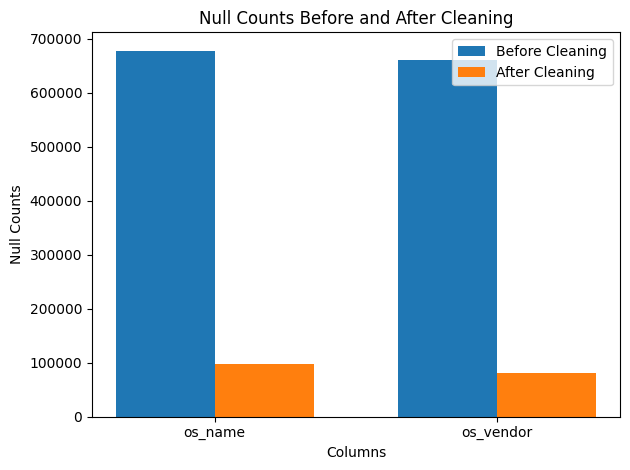

In [18]:
labels = ['os_name', 'os_vendor']
initial_nulls = [initial_os_name_null_count, initial_os_vendor_null_count]
final_nulls = [final_os_name_null_count, final_os_vendor_null_count]

x = list(range(len(labels)))  # convert range to list

fig, ax = plt.subplots()
width = 0.35  # the width of the bars

rects1 = ax.bar([i - width/2 for i in x], initial_nulls, width, label='Before Cleaning')
rects2 = ax.bar([i + width/2 for i in x], final_nulls, width, label='After Cleaning')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Columns')
ax.set_ylabel('Null Counts')
ax.set_title('Null Counts Before and After Cleaning')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [ ]:
device_filled.coalesce(1).write.format("csv").option("header", "true").save("device_cleaned.csv")

24/05/31 18:10:08 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 2081189 ms exceeds timeout 120000 ms
24/05/31 18:10:08 WARN SparkContext: Killing executors is not supported by current scheduler.
24/05/31 18:10:10 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$